In [1]:
FN = '160206-FCN_model'

151219-FCN_tutorial => add equaizier on images

Define all examples in Sunnybrook data set and also handle training/validation examples that have multiple scans

In [2]:
import dicom, lmdb, cv2, re, sys
import os, fnmatch, shutil, subprocess
from IPython.utils import io
import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
from matplotlib import image
%matplotlib inline
import warnings
warnings.filterwarnings('ignore') # we ignore a RuntimeWarning produced from dividing by zero

CAFFE_ROOT = "/home/ubuntu/caffe_FCN/"
caffe_path = os.path.join(CAFFE_ROOT, "python")
if caffe_path not in sys.path:
    sys.path.insert(0, caffe_path)

import caffe
import json

In [3]:
from scipy.ndimage.morphology import binary_erosion

[Sunnybrook dataset](http://smial.sri.utoronto.ca/LV_Challenge/Data.html)

```bash
mkdir data/Sunnybrook_data
cd data/Sunnybrook_data
aws s3 cp s3://udikaggle/dsb2/sunnybrook.tgz .
tar xfz sunnybrook.tgz
rm sunnybrook.tgz
unzip contoursPat1
unzip contoursPat2
unzip contoursPat3
rm contoursPat1 contoursPat2 contoursPat3
unzip training
rm training
unzip validation
rm validation
unzip onlineComponent
rm onlineComponent
```

In [4]:
!head data/Sunnybrook_data/README

README
Nov.19, 2009

Part 1  Refers to the portion of the database used for the online challenge on the day of the workshop.

Part 2 Refers to the portion of the database used for the validation (testing) challenge that formed the basis of the results for submitted papers.

Part 3 Refers to the portion of the database used for the initial training phase of the challenge.

Sept. 2, 2010


## Tutorial Walkthrough

### Step 1: Load the Sunnybrook dataset
The Sunnybrook dataset consists of training images and corresponding ground truth contours used to evaluate methods for automatically segmenting LV contours from a series of MRI SAX scans in DICOM format. The dataset provides ground-truth contours for the following objects of interest: the endocardium, the epicardium, and the two largest papillary muscles. In this tutorial, we only concern ourselves with the endocardium contours of the LV, which correspond to the `i` component of the contour filename, during cardiac systole and diastole cycles. Take a few moments to study the code snippet below. Its main functionality is to take the raw Sunnybrook data and convert it into LMDB databases for Caffe modeling and consumption. The main helper functions are summarized as follows:
* `get_all_contours` function walks through a directory containing contour files, and extracts the necessary case study number and image number from a contour filename using the `Contour` class.
* `load_contour` function maps each contour file to a DICOM image, according to a case study number, using the SAX_SERIES dictionary and the extracted image number. Upon successful mapping, the function returns NumPy arrays for a pair of DICOM image and contour file, or label.
* `export_all_contours` function leverages Caffe's Python API to load a pair of image and label NumPy arrays into a pair of LMDB databases. This technique is useful for constructing ground truth databases from any scalar, vector, or matrix data. During training and testing, Caffe will traverse the LMDB databases in *lockstep* to sync the loading of image and label data.

The SAX_SERIES dictionary can be determined from the following procedure:

1. Go to the contours folder for the study you are examining (for example "Sunnybrook\ Cardiac\ MR\ Database\ ContoursPart1/OnlineDataContours/SC-HF-I-10/contours-manual/IRCCI-expert"), and look for the highest image number. Then, go to the study folder and search for files containing this number (using the bash command `grep`, for example).
You will most likely get one or two images. If you only get one image, your job is done because only one series in the study has enough images to correspond to the contours. If you get two or more, you will have to examine the series manually. For example, the highest contoured image in study SC-HF-I-10, part of the online dataset, is IM-0001-0220-icontour.txt, or image 220. (This is just an example, choose the highest number regardless of if it is an interior or exterior contour.) Going back to the study folder proper, we can see that the only series with an image 220 are series 24 (IM-0024-0220.dcm) and series 34 (IM-0034-0220.dcm).

2. Using the DICOM viewer of your choice, examine the series which returns results above and visually confirm which is the short axis stack. This can be tricky unless you have spent time looking at MRI images and have a general idea of what a heart looks like along the short axis. The best advice I can give is to look for the left ventricle, which appears on the short axis stack as a smooth circular region lighter than its surroundings, that should grow, then shrink as you go from the base of the heart to the apex. Other views, such as the two-chamber view, will have oblong shapes corresponding to the appearance of the heart from the side, not down its central axis. In addition, there are some studies that may look like the short-axis stack but occasionally fade to static, or dramatically shift contrast over the course of a cycle; these are not suitable for model training. In other words, always attempt to find the "cleanest" series out of those you identified in the first step. In our example, inspection of series 34 reveals that it regularly devolves into distorted static patterns; therefore, for study "SC-HF-I-10" we can create a mapping "0024".

### Manually find SAX_SERIES

In [5]:
SUNNYBROOK_ROOT_PATH = "data/Sunnybrook_data/"

TRAIN_CONTOUR_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,
                            "Sunnybrook Cardiac MR Database ContoursPart3",
                            "TrainingDataContours")
TRAIN_IMG_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,
                        "challenge_training")
VALIDATION_CONTOUR_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,
                            "Sunnybrook Cardiac MR Database ContoursPart2",
                            "ValidationDataContours")
VALIDATION_IMG_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,
                        "challenge_validation")
ONLINE_CONTOUR_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,
                            "Sunnybrook Cardiac MR Database ContoursPart1",
                            "OnlineDataContours")
ONLINE_IMG_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,
                        "challenge_online","challenge_online")
sunnybrook_paths = [(TRAIN_CONTOUR_PATH,TRAIN_IMG_PATH),(VALIDATION_CONTOUR_PATH,VALIDATION_IMG_PATH),(ONLINE_CONTOUR_PATH,ONLINE_IMG_PATH)]

In [6]:
class Contour(object):
    def __init__(self, ctr_path):
        self.ctr_path = ctr_path
        match = re.search(r"/([^/]*)/contours-manual/IRCCI-expert/IM-0001-(\d{4})-icontour-manual.txt", ctr_path)
        self.case = shrink_case(match.group(1))
        self.img_no = int(match.group(2))
    
    def __str__(self):
        return "<Contour for case %s, image %d>" % (self.case, self.img_no)
    
    __repr__ = __str__

def shrink_case(case):
    toks = case.split("-")
    def shrink_if_number(x):
        try:
            cvt = int(x)
            return str(cvt)
        except ValueError:
            return x
    return "-".join([shrink_if_number(t) for t in toks])

def get_all_contours(contour_path):
    contours = [os.path.join(dirpath, f)
        for dirpath, dirnames, files in os.walk(contour_path)
        for f in fnmatch.filter(files, 'IM-0001-*-icontour-manual.txt')]
    print("Shuffle data")
    np.random.shuffle(contours)
    print("Number of examples: {:d}".format(len(contours)))
    extracted = map(Contour, contours)
    return extracted

def load_contour(contour, img_path, SAX_SERIES):
    if contour.case not in SAX_SERIES:
#         print('contour %s not defined in SAX_SERIES'%contour.case)
        return None, None
    filename = "IM-%s-%04d.dcm" % (SAX_SERIES[contour.case], contour.img_no)
    full_path = os.path.join(img_path, contour.case, filename)
    f = dicom.read_file(full_path)
    img = f.pixel_array.astype(np.int)
    assert img.shape == (256,256)
    ctrs = np.loadtxt(contour.ctr_path, delimiter=" ").astype(np.int)
    label = np.zeros_like(img, dtype="uint8")
    cv2.fillPoly(label, [ctrs], 1)
    return img, label

In [7]:
for contour_path, img_path in sunnybrook_paths:
    studies = !ls "{contour_path}"
    studies = filter(lambda x: x.startswith('SC-'),studies)
    for study in studies:
        print
        print study
        images = !ls -1 "{contour_path+'/'+study}/contours-manual/IRCCI-expert"
        imageno = images[-1].split('-')[2]
        study = study.split('-')
        if study[-1].startswith('0'):
            study[-1] = study[-1][1:]
        study = '-'.join(study)
        !find "{img_path+'/'+study}" -name "*-{imageno}.dcm"


SC-HF-I-01
data/Sunnybrook_data/challenge_training/SC-HF-I-1/IM-0004-0219.dcm
data/Sunnybrook_data/challenge_training/SC-HF-I-1/IM-0005-0219.dcm

SC-HF-I-02
data/Sunnybrook_data/challenge_training/SC-HF-I-2/IM-0106-0220.dcm
data/Sunnybrook_data/challenge_training/SC-HF-I-2/IM-0107-0220.dcm

SC-HF-I-04
data/Sunnybrook_data/challenge_training/SC-HF-I-4/IM-0118-0200.dcm
data/Sunnybrook_data/challenge_training/SC-HF-I-4/IM-0116-0200.dcm

SC-HF-I-40
data/Sunnybrook_data/challenge_training/SC-HF-I-40/IM-0134-0200.dcm

SC-HF-NI-03
data/Sunnybrook_data/challenge_training/SC-HF-NI-3/IM-0379-0200.dcm

SC-HF-NI-04
data/Sunnybrook_data/challenge_training/SC-HF-NI-4/IM-0506-0189.dcm
data/Sunnybrook_data/challenge_training/SC-HF-NI-4/IM-0501-0189.dcm

SC-HF-NI-34
data/Sunnybrook_data/challenge_training/SC-HF-NI-34/IM-0446-0239.dcm
data/Sunnybrook_data/challenge_training/SC-HF-NI-34/IM-0450-0239.dcm

SC-HF-NI-36
data/Sunnybrook_data/challenge_training/SC-HF-NI-36/IM-0476-0260.dcm
data/Sunnybrook_dat

when building SAX_SERIES select the part you are working on

In [8]:
part=1

In [9]:
contour_path, img_path = sunnybrook_paths[part]
ctrs = get_all_contours(contour_path)
len(ctrs)

Shuffle data
Number of examples: 266


266

then copy paste into s one of the studies that has multiple options

In [10]:
s = """
SC-HF-I-05
data/Sunnybrook_data/challenge_validation/SC-HF-I-5/IM-0156-0200.dcm
data/Sunnybrook_data/challenge_validation/SC-HF-I-5/IM-0174-0200.dcm
"""
s = s.strip().splitlines()
study = s[0].split()[0].split('-')
if study[-1].startswith('0'):
    study[-1] = study[-1][1:]
study = '-'.join(study)
imagenos = map(lambda x: x.split('/')[-1].split('-')[1], s[1:])
study, imagenos

('SC-HF-I-5', ['0156', '0174'])

look at the images and select the column of images that better fits the manually marked region.
Use the imageno from imagenos of the column you selected and place the study,imageno pair in SAX_SERIES

In [11]:
# import colormaps as cmaps
# cmaps.viridis
import copy

my_cmap = copy.copy(plt.cm.get_cmap('viridis')) # get a copy of the gray color map
my_cmap.set_bad(alpha=0) # set how the colormap handles 'bad' values

def show(img, label):
    label = copy.copy(label)
    label = label.astype(float)
    label -= binary_erosion(binary_erosion(label))
    label[label < 0.5] = np.nan
    label[0,0] = 0
    plt.imshow(img,cmap=my_cmap) #,extent=(0,256,0,256))
    plt.imshow(label,cmap=my_cmap) #,extent=(0,256,0,256))

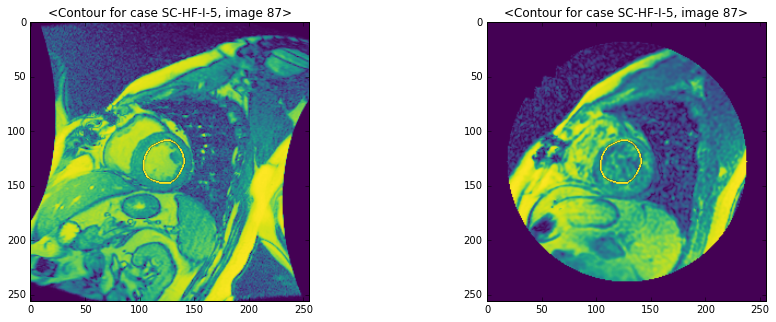

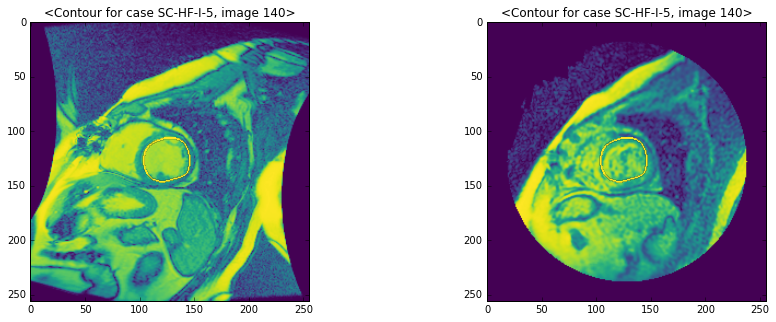

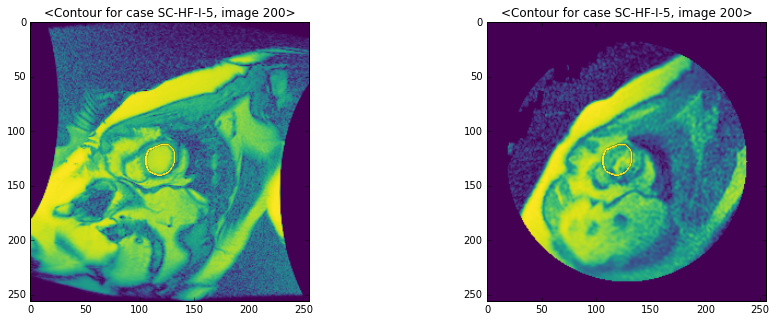

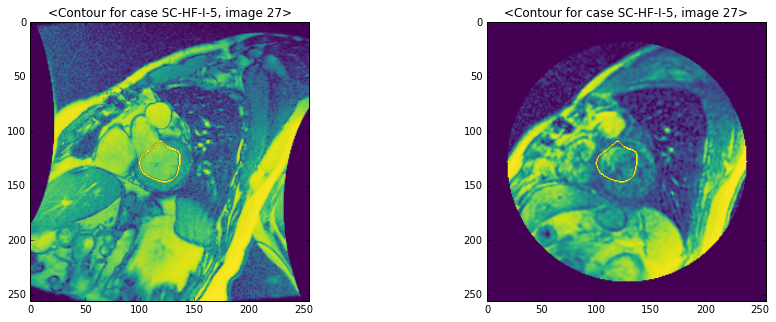

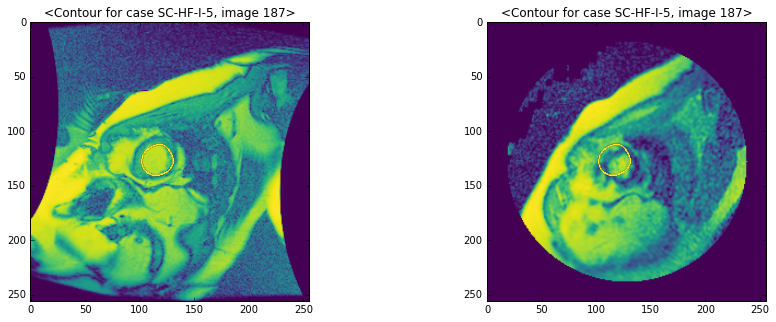

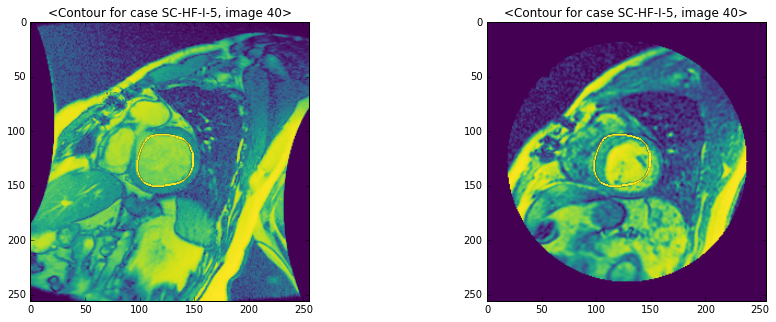

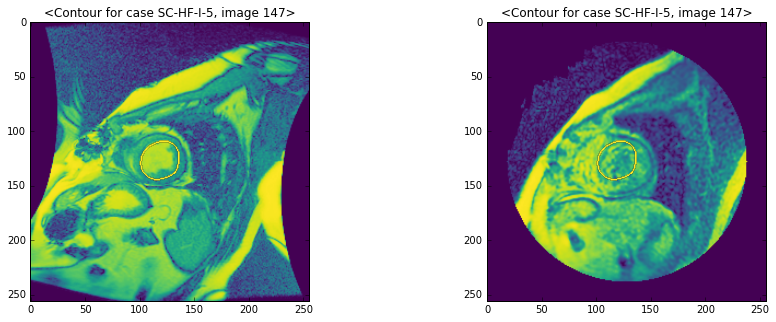

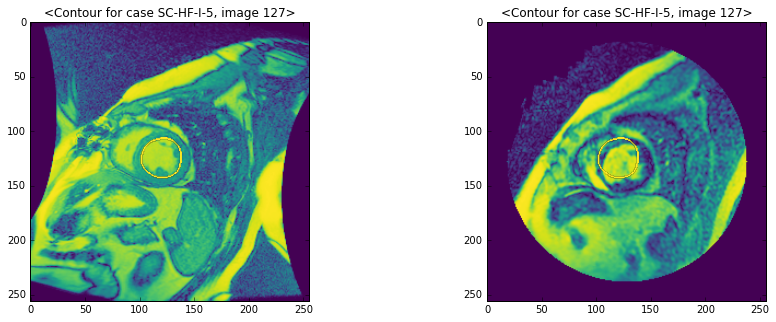

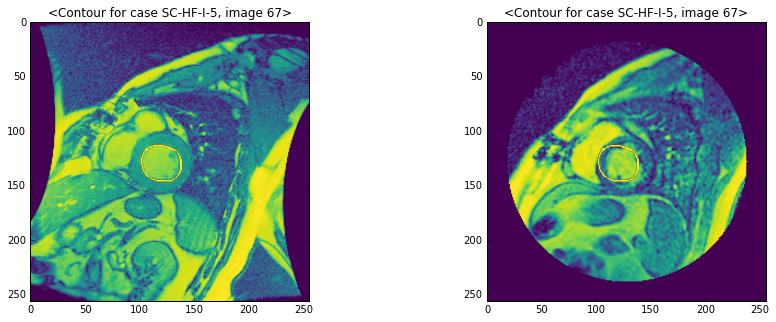

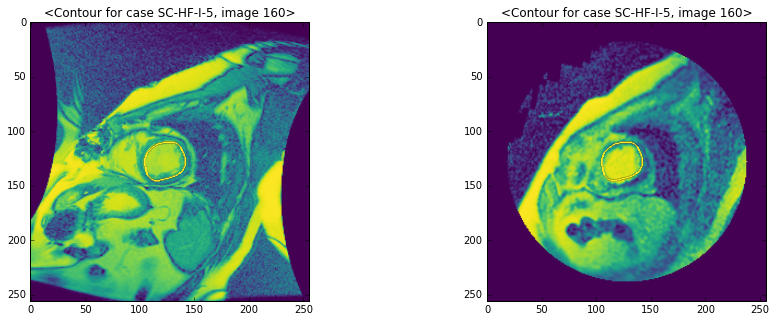

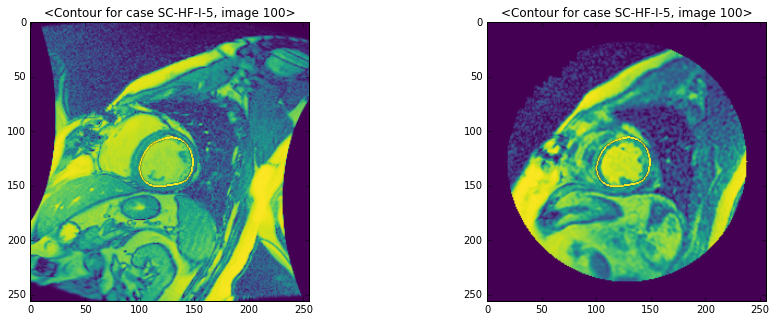

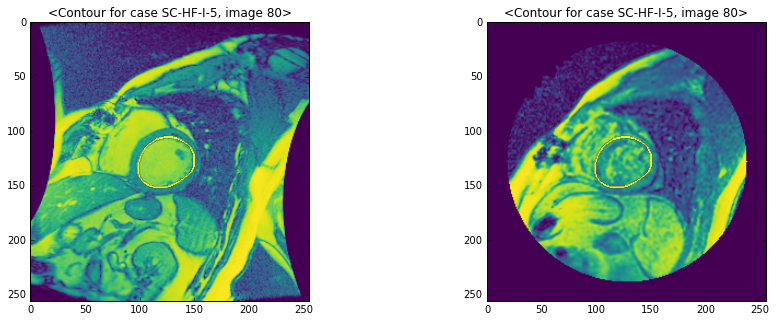

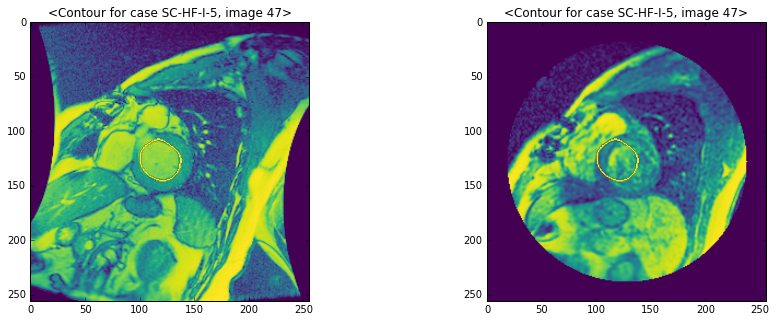

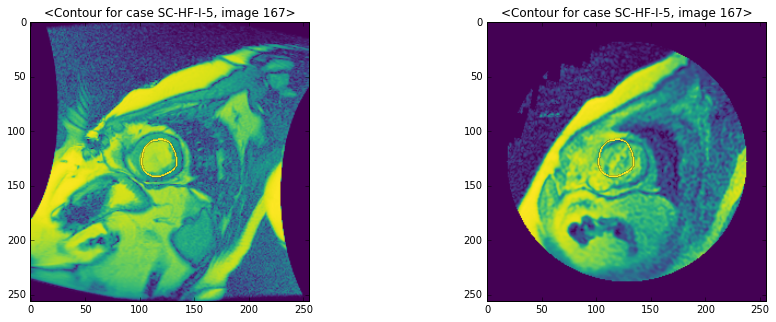

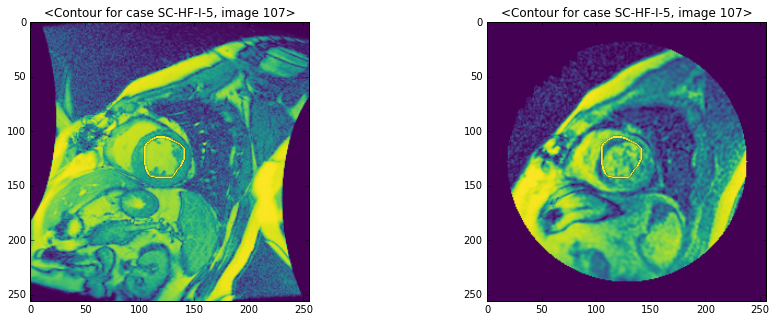

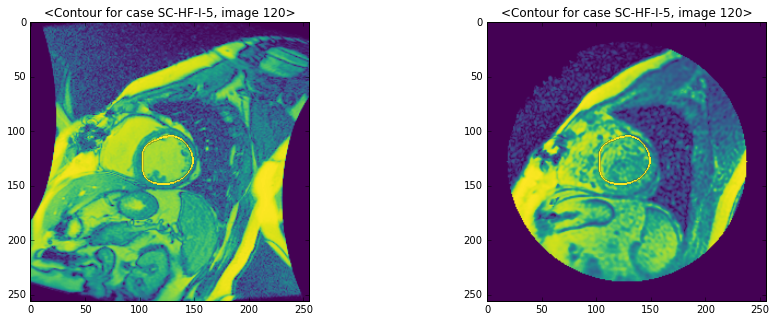

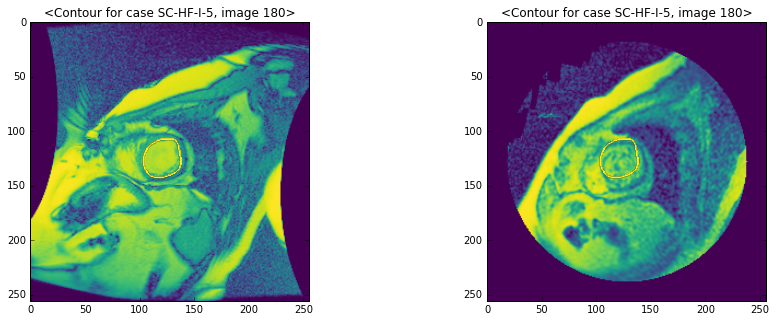

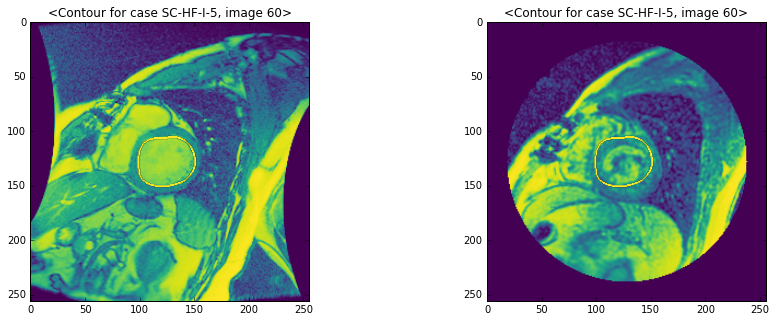

In [13]:
SAX_SERIES = {}
for ctr in ctrs:
    if ctr.case != study:
        continue
    plt.figure(figsize=(15,5))
    for i, imageno in enumerate(imagenos):
        SAX_SERIES[study] = imageno
        img, label = load_contour(ctr, img_path, SAX_SERIES)
        img = cv2.equalizeHist(np.array(img * 255./img.max(), dtype = np.uint8))
        if img is None or label is None:
            continue
        plt.subplot(1,len(imagenos),i+1)
        show(img,label)
        plt.title(str(ctr))
    plt.show()

In [14]:
# convert from contour case to image offset
SAX_SERIES = {
    # challenge training from Kaggle tutorial
    "SC-HF-I-1": "0004",
    "SC-HF-I-2": "0106",
    "SC-HF-I-4": "0116",
    "SC-HF-I-40": "0134",
    "SC-HF-NI-3": "0379",
    "SC-HF-NI-4": "0501",
    "SC-HF-NI-34": "0446",
    "SC-HF-NI-36": "0474",
    "SC-HYP-1": "0550",
    "SC-HYP-3": "0650",
    "SC-HYP-38": "0734",
    "SC-HYP-40": "0755",###
    "SC-N-2": "0898",###
    "SC-N-3": "0915",###
    "SC-N-40": "0944",
    # challenge validation
    "SC-HF-I-8": "0226",
    "SC-HF-NI-7": "0523",
    "SC-HF-NI-11": "0270",
    'SC-N-7':'1009',
    'SC-N-6':'0984',
    'SC-N-5':'0963',
    'SC-HYP-37':'0702',
    'SC-HYP-8':'0796',
    'SC-HYP-7':'0007',
    'SC-HYP-6':'0767',
    'SC-HF-NI-33':'0424',
    'SC-HF-NI-31':'0401',
    'SC-HF-I-7':'0209',
    'SC-HF-I-6':'0180',
    'SC-HF-I-5':'0156',
    # challenge online
    "SC-HF-I-9": "0241",
    "SC-HF-I-10": "0024",
    "SC-HF-I-12": "0062",
    "SC-HF-NI-12": "0286",
    "SC-HF-NI-13": "0304",
    "SC-HF-NI-15": "0359",
    'SC-N-11':'0877',
    'SC-N-10':'0851',
    'SC-N-9':'1031',
    'SC-HYP-12':'0629',
    'SC-HYP-11':'601',
    'SC-HYP-10':'0579',
    'SC-HYP-9':'0003',
    'SC-HF-NI-14':'0331',
    'SC-HF-I-11':'0043',
    'SC-HF-I-10':'0024',
}

### export to lmdb

In [17]:
def export_all_contours(contours, img_path, lmdb_img_name, lmdb_label_name, counter=0):
    if counter == 0:
        for lmdb_name in [lmdb_img_name, lmdb_label_name]:
            db_path = os.path.abspath(lmdb_name)
            if os.path.exists(db_path):
                shutil.rmtree(db_path)
                
    counter_img = counter_label = counter
    
    batchsz = 100
    print("Processing {:d} images and labels...".format(len(contours)))
    for i in xrange(int(np.ceil(len(contours) / float(batchsz)))):
        batch = contours[(batchsz*i):(batchsz*(i+1))]
        if len(batch) == 0:
            break
        imgs, labels = [], []
        for idx,ctr in enumerate(batch):
            try:
                img, label = load_contour(ctr, img_path, SAX_SERIES)
                if img is None or label is None:
                    continue
#                 print(ctr)
                img = cv2.equalizeHist(np.array(img * 255./img.max(), dtype = np.uint8))
                imgs.append(img)
                labels.append(label)
#                 if idx % 20 == 0:
#                     print ctr
#                     plt.imshow(img)
#                     plt.show()
#                     plt.imshow(label)
#                     plt.show()
            except IOError:
                continue
        db_imgs = lmdb.open(lmdb_img_name, map_size=1e12)
        with db_imgs.begin(write=True) as txn_img:
            for img in imgs:
                datum = caffe.io.array_to_datum(np.expand_dims(img, axis=0))
                txn_img.put("{:0>10d}".format(counter_img), datum.SerializeToString())
                counter_img += 1
        print("Processed {:d} images".format(counter_img))
        db_labels = lmdb.open(lmdb_label_name, map_size=1e12)
        with db_labels.begin(write=True) as txn_label:
            for lbl in labels:
                datum = caffe.io.array_to_datum(np.expand_dims(lbl, axis=0))
                txn_label.put("{:0>10d}".format(counter_label), datum.SerializeToString())
                counter_label += 1
        print("Processed {:d} labels".format(counter_label))
    db_imgs.close()
    db_labels.close()
    assert counter_label == counter_img
    return counter_img

In [18]:
SPLIT_RATIO = 0.1
print("Mapping ground truth contours to images...")
counter_train = 0
counter_val = 0
for contour_path, img_path in [
                               (TRAIN_CONTOUR_PATH,TRAIN_IMG_PATH),
                               (VALIDATION_CONTOUR_PATH,VALIDATION_IMG_PATH),
                               (ONLINE_CONTOUR_PATH,ONLINE_IMG_PATH)
                              ]:
    ctrs = get_all_contours(contour_path)
    val_ctrs = ctrs[0:int(SPLIT_RATIO*len(ctrs))]
    train_ctrs = ctrs[int(SPLIT_RATIO*len(ctrs)):]
    print("Done mapping ground truth contours to images %s"%contour_path)
    print("\nBuilding LMDB for train...")
    counter_train = export_all_contours(train_ctrs, img_path, "data/train_images_lmdb", "data/train_labels_lmdb", counter=counter_train)
    print("\nBuilding LMDB for val...")
    counter_val = export_all_contours(val_ctrs, img_path, "data/val_images_lmdb", "data/val_labels_lmdb", counter=counter_val)

Mapping ground truth contours to images...
Shuffle data
Number of examples: 260
Done mapping ground truth contours to images data/Sunnybrook_data/Sunnybrook Cardiac MR Database ContoursPart3/TrainingDataContours

Building LMDB for train...
Processing 234 images and labels...
Processed 100 images
Processed 100 labels
Processed 200 images
Processed 200 labels
Processed 234 images
Processed 234 labels

Building LMDB for val...
Processing 26 images and labels...
Processed 26 images
Processed 26 labels
Shuffle data
Number of examples: 266
Done mapping ground truth contours to images data/Sunnybrook_data/Sunnybrook Cardiac MR Database ContoursPart2/ValidationDataContours

Building LMDB for train...
Processing 240 images and labels...
Processed 334 images
Processed 334 labels
Processed 434 images
Processed 434 labels
Processed 474 images
Processed 474 labels

Building LMDB for val...
Processing 26 images and labels...
Processed 52 images
Processed 52 labels
Shuffle data
Number of examples: 27

### Step 2: Instantiate and solve a Caffe FCN model

In [19]:
%%bash
cat > data/fcn_train.prototxt <<EOF
name: "FCN"
force_backward: true
layer {
  name: "data"
  type: "Data"
  top: "data"
  transform_param {
    mirror: false
    crop_size: 0
    mean_value: 77
  }
  data_param {
    source: "data/train_images_lmdb/"
    batch_size: 1
#     shuffle: true
    backend: LMDB
  }
}
layer {
  name: "label"
  type: "Data"
  top: "label"
  data_param {
    source: "data/train_labels_lmdb/"
    batch_size: 1
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 100
    pad: 50
    kernel_size: 5
    group: 1
    stride: 2
    weight_filler {
      type: "gaussian"
      mean: 0.0
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "conv1"
  top: "conv1"
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 200
    pad: 0
    kernel_size: 5
    group: 1
    stride: 2
    weight_filler {
      type: "gaussian"
      mean: 0.0
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu2"
  type: "ReLU"
  bottom: "conv2"
  top: "conv2"
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "conv2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv3"
  type: "Convolution"
  bottom: "pool2"
  top: "conv3"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 300
    pad: 0
    kernel_size: 3
    group: 1
    stride: 1
    weight_filler {
      type: "gaussian"
      mean: 0.0
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu3"
  type: "ReLU"
  bottom: "conv3"
  top: "conv3"
}
layer {
  name: "conv4"
  type: "Convolution"
  bottom: "conv3"
  top: "conv4"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 300
    pad: 0
    kernel_size: 3
    group: 1
    stride: 1
    weight_filler {
      type: "gaussian"
      mean: 0.0
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu4"
  type: "ReLU"
  bottom: "conv4"
  top: "conv4"
}
layer {
  name: "drop"
  type: "Dropout"
  bottom: "conv4"
  top: "conv4"
  dropout_param {
    dropout_ratio: 0.1
  }
}
layer {
  name: "score_classes"
  type: "Convolution"
  bottom: "conv4"
  top: "score_classes"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 2
    pad: 0
    kernel_size: 1
    group: 1
    stride: 1
    weight_filler {
      type: "gaussian"
      mean: 0.0
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "upscore"
  type: "Deconvolution"
  bottom: "score_classes"
  top: "upscore"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 2
    bias_term: true
    kernel_size: 31
    pad: 8
    stride: 16
    weight_filler { type: "bilinear" }
    bias_filler { type: "constant" value: 0.1 }
  }
}
layer {
  name: "score"
  type: "Crop"
  bottom: "upscore"
  bottom: "data"
  top: "score"
}
layer {
  name: "loss"
  type: "SoftmaxWithLoss"
  bottom: "score"
  bottom: "label"
  top: "loss"
  loss_param {
    normalize: true
  }
}
EOF

In [20]:
%%bash
cat > data/fcn_test.prototxt <<EOF
name: "FCN"
force_backward: true
layer {
  name: "data"
  type: "Data"
  top: "data"
  transform_param {
    mirror: false
    crop_size: 0
    mean_value: 77
  }
  data_param {
    source: "data/val_images_lmdb/"
    batch_size: 1
    backend: LMDB
  }
}
layer {
  name: "label"
  type: "Data"
  top: "label"
  data_param {
    source: "data/val_labels_lmdb/"
    batch_size: 1
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 100
    pad: 50
    kernel_size: 5
    group: 1
    stride: 2
    weight_filler {
      type: "gaussian"
      mean: 0.0
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "conv1"
  top: "conv1"
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 200
    pad: 0
    kernel_size: 5
    group: 1
    stride: 2
    weight_filler {
      type: "gaussian"
      mean: 0.0
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu2"
  type: "ReLU"
  bottom: "conv2"
  top: "conv2"
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "conv2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv3"
  type: "Convolution"
  bottom: "pool2"
  top: "conv3"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 300
    pad: 0
    kernel_size: 3
    group: 1
    stride: 1
    weight_filler {
      type: "gaussian"
      mean: 0.0
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu3"
  type: "ReLU"
  bottom: "conv3"
  top: "conv3"
}
layer {
  name: "conv4"
  type: "Convolution"
  bottom: "conv3"
  top: "conv4"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 300
    pad: 0
    kernel_size: 3
    group: 1
    stride: 1
    weight_filler {
      type: "gaussian"
      mean: 0.0
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu4"
  type: "ReLU"
  bottom: "conv4"
  top: "conv4"
}
# layer {
#   name: "drop"
#   type: "Dropout"
#   bottom: "conv4"
#   top: "conv4"
#   dropout_param {
#     dropout_ratio: 0.5
#   }
# }
layer {
  name: "score_classes"
  type: "Convolution"
  bottom: "conv4"
  top: "score_classes"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 2
    pad: 0
    kernel_size: 1
    group: 1
    stride: 1
    weight_filler {
      type: "gaussian"
      mean: 0.0
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "upscore"
  type: "Deconvolution"
  bottom: "score_classes"
  top: "upscore"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 2
    bias_term: true
    kernel_size: 31
    pad: 8
    stride: 16
    weight_filler { type: "bilinear" }
    bias_filler { type: "constant" value: 0.1 }
  }
}
layer {
  name: "score"
  type: "Crop"
  bottom: "upscore"
  bottom: "data"
  top: "score"
}
layer {
  name: "loss"
  type: "SoftmaxWithLoss"
  bottom: "score"
  bottom: "label"
  top: "loss"
  loss_param {
    normalize: true
  }
}
layer {
  name: "accuracy"
  type: "Accuracy"
  bottom: "score"
  bottom: "label"
  top: "accuracy"
}
EOF

Now we specify the solver protocol for the nets, with the necessary training, testing, and learning parameters. This solver instance, `fcn_solver.prototxt`, is written as a `prototxt` file and must be manually created as a file on disk. Once created, we can take a closer look at the solver.

In [21]:
%%bash
cat > data/fcn_solver.prototxt <<EOF


# The train/test net protocol buffers definition
train_net: "data/fcn_train.prototxt"
test_net: "data/fcn_test.prototxt"

# test_iter specifies how many forward passes the test should carry out.
# In our case, we have test batch size 1 and 26 test iterations,
# covering the full size of testing images.
test_iter: 26

# Carry out testing every 200 training iterations.
test_interval: 200

# display interval
display: 200
average_loss: 200

# The learning rate policy
lr_policy: "multistep"
stepvalue: 10000
gamma: 0.1

# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005

# The maximum number of iterations
max_iter: 15000

# snapshot intervals to disk
snapshot: 2500
snapshot_prefix: "data/model_logs/fcn"

# misc settings
test_initialization: true
random_seed: 5
#solver_type: NESTEROV
EOF

In [22]:
!mkdir data/model_logs

mkdir: cannot create directory ‘data/model_logs’: File exists


When we have defined the train/test nets and specified their solver protocol, we can load the solver into Python and begin stepping in the direction of the negative gradient using Caffe's `SGDSolver`.

In [23]:
caffe.set_mode_gpu() # or caffe.set_mode_cpu() for machines without a GPU
try:
    del solver # it is a good idea to delete the solver object to free up memory before instantiating another one
    solver = caffe.SGDSolver('data/fcn_solver.prototxt')
except NameError:
    solver = caffe.SGDSolver('data/fcn_solver.prototxt')

As a first step in our net exploration, we inspect the different types of blob defined in our Caffe model. According to the Caffe documentation:

> A blob is an N-dimensional array stored in a C-contiguous fashion. Caffe stores and communicates data using blobs. Blobs provide a unified memory interface holding data; e.g., batches of images, model parameters, and derivatives for optimization. The conventional blob dimensions for batches of image data are number N x channel K x height H x width W.

Since our data consists of grayscale images of shape 256 x 256, and we specify a batch size of 1 in our nets, our `data` blob dimensions are 1 x 1 x 256 x 256.

In [24]:
# each blob has dimensions batch_size x channel_dim x height x width
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (1, 1, 256, 256)),
 ('data_data_0_split_0', (1, 1, 256, 256)),
 ('data_data_0_split_1', (1, 1, 256, 256)),
 ('label', (1, 1, 256, 256)),
 ('conv1', (1, 100, 176, 176)),
 ('pool1', (1, 100, 88, 88)),
 ('conv2', (1, 200, 42, 42)),
 ('pool2', (1, 200, 21, 21)),
 ('conv3', (1, 300, 19, 19)),
 ('conv4', (1, 300, 17, 17)),
 ('score_classes', (1, 2, 17, 17)),
 ('upscore', (1, 2, 271, 271)),
 ('score', (1, 2, 256, 256)),
 ('loss', ())]

Next, we inspect the parameter blobs, which store the model weights. Note that all layers with learnable weights have the `weight_filler` configuration; it is necessary to (randomly) initialize weights before the start of training and update them during the training process through gradient descent. Each parameter blob is updated using a diff blob that has the same dimensions. A diff blob stores the gradient of the loss function computed by the network with respect to the corresponding data blob during backward propagation of errors (backprop). In addition, access to diff blobs is useful for at least two purposes: (1) model debugging and diagnosis - a model with zero diffs does not compute gradients and hence does not learn anything, which may indicate a vanishing-gradient problem; (2) visualization of class saliency maps for input images, as suggested in the paper [Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](http://arxiv.org/pdf/1312.6034.pdf).


In [25]:
# print the layers with learnable weights and their dimensions
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (100, 1, 5, 5)),
 ('conv2', (200, 100, 5, 5)),
 ('conv3', (300, 200, 3, 3)),
 ('conv4', (300, 300, 3, 3)),
 ('score_classes', (2, 300, 1, 1)),
 ('upscore', (2, 2, 31, 31))]

In [26]:
# print the biases associated with the weights
[(k, v[1].data.shape) for k, v in solver.net.params.items()]

[('conv1', (100,)),
 ('conv2', (200,)),
 ('conv3', (300,)),
 ('conv4', (300,)),
 ('score_classes', (2,)),
 ('upscore', (2,))]

In [27]:
# params and diffs have the same dimensions
[(k, v[0].diff.shape) for k, v in solver.net.params.items()]

[('conv1', (100, 1, 5, 5)),
 ('conv2', (200, 100, 5, 5)),
 ('conv3', (300, 200, 3, 3)),
 ('conv4', (300, 300, 3, 3)),
 ('score_classes', (2, 300, 1, 1)),
 ('upscore', (2, 2, 31, 31))]

Finally, before we begin solving our nets it is a good idea to verify that the nets correctly load the data and that gradients are propagating through the filters to update the weights.

In [28]:
# forward pass with randomly initialized weights
solver.net.forward()  # train net
solver.test_nets[0].forward()  # test net (more than one net is supported)

{'accuracy': array(0.016357421875, dtype=float32),
 'loss': array(0.6931471824645996, dtype=float32)}

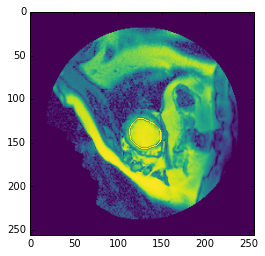

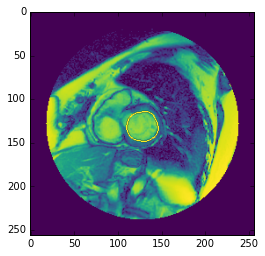

In [29]:
# visualize the image data and its correpsonding label from the train net
i=0
img_train = solver.net.blobs['data'].data[i,0,...]
label_train = solver.net.blobs['label'].data[i,0,...]
show(img_train,label_train)
plt.show()

# visualize the image data and its correpsonding label from the test net
img_test = solver.test_nets[0].blobs['data'].data[i,0,...]
label_test = solver.test_nets[0].blobs['label'].data[i,0,...]
show(img_test,label_test)
plt.show()

In [30]:
# take one step of stochastic gradient descent consisting of both forward pass and backprop
solver.step(1)

In [31]:
# visualize gradients after backprop. If non-zero, then gradients are properly propagating and the nets are learning something
# gradients are shown here as 10 x 10 grid of 5 x 5 filters
plt.imshow(solver.net.params['conv1'][0].diff[:,0,...].reshape(10,10,5,5).transpose(0,2,1,3).reshape(10*5,10*5), 'gray')
plt.show()

It looks like images and labels are correctly loaded in both train and test nets, and gradients are propagating through `conv1` layer, which is the lowest (first) layer of the network. That is certainly good news. Now that we are confident the nets have been properly defined and loaded, let's allow the model to train according to the protocol specified in `fcn_solver.prototxt`. There are two ways to do this:

1. Execute the command `solver.solve()` and let the solver take care of the rest. This command logs output to standard output, or in the terminal.
2. One can use a Python subprocess module to call the Caffe binary from the shell and redirect the output logs to a file on disk for further analysis. This is the preferred method.

In [32]:
%%time
ret = subprocess.call(os.path.join(CAFFE_ROOT, 'build/tools/caffe') + ' ' + 'train -solver=data/fcn_solver.prototxt -gpu 0 2> data/fcn_train.log', shell=True)

CPU times: user 332 ms, sys: 21.9 ms, total: 354 ms
Wall time: 12min 7s


run
```bash
tail -f data/fcn_train.log
```
to track progress

In [33]:
!tail data/fcn_train.log

I0206 22:50:55.863239  6760 solver.cpp:258]     Train net output #0: loss = 0.0077747 (* 1 = 0.0077747 loss)
I0206 22:50:55.863257  6760 solver.cpp:571] Iteration 14800, lr = 0.001
I0206 22:51:04.665671  6760 solver.cpp:449] Snapshotting to binary proto file data/model_logs/fcn_iter_15000.caffemodel
I0206 22:51:04.728449  6760 solver.cpp:734] Snapshotting solver state to binary proto filedata/model_logs/fcn_iter_15000.solverstate
I0206 22:51:04.758446  6760 solver.cpp:326] Iteration 15000, loss = 0.00586576
I0206 22:51:04.758530  6760 solver.cpp:346] Iteration 15000, Testing net (#0)
I0206 22:51:05.510478  6760 solver.cpp:414]     Test net output #0: accuracy = 0.995928
I0206 22:51:05.510567  6760 solver.cpp:414]     Test net output #1: loss = 0.00946703 (* 1 = 0.00946703 loss)
I0206 22:51:05.510581  6760 solver.cpp:331] Optimization Done.
I0206 22:51:05.510589  6760 caffe.cpp:214] Optimization Done.


Caffe trains the model in about 12 minutes on a AWS g2.2xlarge using NVIDIA GRID K520 with 2GB of dedicated GPU memory. The final validation accuracy is 0.996, in terms of pixel-wise binary accuracy, as shown below from my training log:

```
Iteration 15000, Testing net (#0)
Test net output #0: accuracy = 0.996439
Test net output #1: loss = 0.0094304 (* 1 = 0.0094304 loss)
Optimization Done.
```

Although we use binary accuracy in this tutorial, be aware that it is a misleading metric to measure performance in this context. In our LV segmentation task, every pixel has an associated class label: 0 for background and 1 for LV. But less than 2 percent of all pixels in the Sunnybrook dataset correspond to the LV class. This is a classic class imbalance problem, where the class distribution is highly skewed and binary accuracy is not a meaningful performance metric. Suppose a model simply predicts all pixels to be background, then its accuracy performance is still greater than 0.98, even though the model is not able to actually detect pixels belonging to the LV object. The reader is encouraged to consider the following alternative performance metrics for LV segmentation: [S&oslash;rensen–Dice index](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) and [average perpendicular distance](http://smial.sri.utoronto.ca/LV_Challenge/Evaluation.html).

In [ ]:
!mv data/model_logs/fcn_iter_15000.caffemodel data/{FN}.model

In [35]:
!gzip -k -f data/{FN}.model

In [36]:
!aws s3 cp data/{FN}.model.gz s3://udikaggle/dsb2/

upload: data/160206-FCN_model.model.gz to s3://udikaggle/dsb2/160206-FCN_model.model.gz


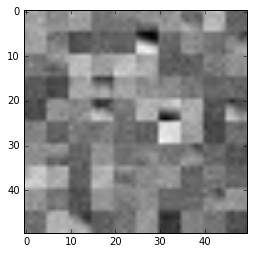

In [37]:
net = caffe.Net('fcn_deploy.prototxt', 'data/%s.model'%FN, caffe.TEST)
# visualize gradients after backprop. If non-zero, then gradients are properly propagating and the nets are learning something
# gradients are shown here as 10 x 10 grid of 5 x 5 filters
plt.imshow(net.params['conv1'][0].data.reshape(10,10,5,5).transpose(0,2,1,3).reshape(10*5,10*5), 'gray')